# Wines dataset personal project

## Regression Approach

### Structure Description
- Compare Regression Models
- Perform HPO
- Compare Optimized models
- Perform Ensembling

In [1]:
# Load standard libraries
%run libs

# Import my utils
import utils

# Import sklearn modules for data processing, train/test splitting
from sklearn.preprocessing import StandardScaler

# Import sklearn modules for train/test splitting
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

# Import some Regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Import some classifiers # List of most classifiers in sklearn: https://stackoverflow.com/questions/41844311/list-of-all-classification-algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Import SKOPT modules for HPO
from skopt import forest_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
from skopt import dump, load

# Define random seed for reproducibility of results
seed = 42

# Standard scaler will be used for all models
scaler = StandardScaler()

libraries loaded


In [2]:
# Define functions

def load_best_parameters(model):
    model_name = model.__class__.__name__
    try:
        res = load(r'output/models/'+model_name)
        param_names = res.param_names
        param_values = res.x
        best_pparameters_dict = dict(zip(param_names, param_values))
        model.set_params(**best_pparameters_dict)
        print(model_name, 'optimized parameters:', best_pparameters_dict)  
    except:
        print(model_name, 'parameters were not previously optimized')
    return model


def save_predicts_to_file(model_name, predicts, file_path):
    try:
        df = pd.read_csv(file_path)
        df[model_name] = predicts
        df.to_csv(file_path, index=False)
        print('Model predicts updated in file', file_path)
    except:
        pd.DataFrame(predicts, columns=[model_name]).to_csv(file_path, index=False)
        print('Model predicts saved in file', file_path)


def get_train_test_predicts(model, X_train, y_train, X_test, y_test, seed):
    model_name = model.__class__.__name__
    print(model_name)

    model = load_best_parameters(model)

    pipeline = make_pipeline(scaler, model)
    cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    y_train_predict = cross_val_predict(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    train_mse = mse(y_train, y_train_predict)
    print('train mse:', train_mse)
    
    # now train the model on all train data and predict for test
    model.fit(X_train,y_train)
    y_test_predict = model.predict(X_test)
    test_mse = mse(y_test, y_test_predict)
    print('test mse:', test_mse)

    save_predicts_to_file(model_name, y_train_predict, r'output/predicts/1st_level_regressors_train_predicts.csv')
    save_predicts_to_file(model_name, y_test_predict, r'output/predicts/1st_level_regressors_test_predicts.csv')
    
    
def plot_shap_feature_importance(model, X, y):
    model = load_best_parameters(model)
    model.fit(X,y)
    shap_values = shap.TreeExplainer(model).shap_values(X)
    try:
        #this should work for classification tasks
        shap.summary_plot(shap_values, X, plot_type='bar', class_names=model.classes_)
    except:
        # this should work for regression tasks
        shap.summary_plot(shap_values, X, plot_type='bar')
    plt.show()


def find_best_hyperparameters(model, X, y, dynamic_params_space, scoring, plot=True, n_splits=5, **HPO_params):
  
    # Get model name
    model_name = model.__class__.__name__
    
    # Get dynamic parameters names: 
    @use_named_args(dynamic_params_space)
    def get_params_names(**dynamic_params):
        return list(dynamic_params.keys())    
    param_names = get_params_names(dynamic_params_space)
        
    # Define an objective function
    @use_named_args(dynamic_params_space)
    def objective(**dynamic_params):
        #model.set_params(**static_params)
        model.set_params(**dynamic_params) 
        pipeline = make_pipeline(scaler, model)
        cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring = scoring, n_jobs=-1)
        val_score = np.mean(scores['test_score'])
        return -val_score
    
    print(model_name, 'model training...')
    # Load previously trained results and get starting point (x0) as best model from previous run
    try:
        res = load(r'output/models/'+model_name)
        x0 = res.x       
    # If not trained before -> no initial point provided
    except:
        x0 = None
    
    res = forest_minimize(objective, dynamic_params_space, x0 = x0, **HPO_params)
    
    # add attribute - parameters names to the res
    res.param_names = param_names

    print('Optimized parameters:    ', res.param_names)
    print('Previous best parameters:', x0)
    print('Current  best parameters:', res.x)
    print('Best score:', res.fun)
    
    # Saved optimization result  
    dump(res, r'output/models/'+model_name, store_objective=False)
        
    if plot == True:
        plt.figure(figsize=(5,2))
        plot_convergence(res)
        try:
            # plot_objective would not work if only one parameter was searched for
            plot_objective(res)
        except:
            pass
    plt.show()
    
def compare_regressors(models, X_train, y_train, X_test, y_test, n_splits, load_best_params, show_predicts, scoring):
    # With the small amount of data - 2000 points only cross-validation is very important
    # Simple train-test split is not robust in this case and one is better to use KFold CV
    train_scores = []
    val_scores = []
    test_scores = []
    model_names = []
    fit_times = []
    
    # iterate over classifiers
    for model in models:
        
        model_name = model.__class__.__name__
        
        if load_best_params:
            model = load_best_parameters(model)
        
        # We need to use pipeline to make feature scaling for each fold so that
        # scaler.fit is done on train and scaler.predict on test
        pipeline = make_pipeline(scaler, model)
        # Now we just pass pipeline to the CV instead of model
        cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, return_train_score=True, scoring = scoring, n_jobs=-1)
        
        fit_time = np.mean(scores['fit_time'])        
        train_score = np.mean(scores['train_score']) #np.mean(scores['train_score'])
        val_score = np.mean(scores['test_score']) #np.mean(scores['test_score'])    

        fit_times.append(fit_time)
        model_names.append(model_name)
        train_scores.append(-train_score)
        val_scores.append(-val_score)   
        
        # Train on all train data, predict for test
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train,y_train)
        y_predict_test = model.predict(X_test)
        mse_test = mse(y_test, y_predict_test)
        
        test_scores.append(mse_test)
        
        if show_predicts:
            print(model_name)
            print('y_test values        :', np.unique(y_test, return_counts=True)[0], 'counts: ', np.unique(y_test, return_counts=True)[1])
            print('y_test_predict values:', np.unique(np.round(y_predict_test), return_counts=True)[0], 'counts:', np.unique(np.round(y_predict_test), return_counts=True)[1])

    results = pd.DataFrame(list(zip(model_names, train_scores, val_scores, test_scores, fit_times)), columns=['model','train_score','val_score', 'test_score', 'fit_time'])
    results = results.sort_values(by=['test_score'], ascending = True)
    results = results.reset_index(drop = True)
    return results

## Load Data

In [3]:
X_train = pd.read_pickle(r'output/data/X_train.pkl')
y_train = pd.read_pickle(r'output/data/y_train.pkl')
X_test  = pd.read_pickle(r'output/data/X_test.pkl')
y_test  = pd.read_pickle(r'output/data/y_test.pkl')

## Compare Regressors

In [4]:
regressors = [DummyRegressor(strategy="mean"),
              LinearRegression(),
              SVR(),
              KNeighborsRegressor(),
              MLPRegressor(random_state=seed,max_iter=2000),
              ExtraTreesRegressor(random_state=seed),
              RandomForestRegressor(random_state=seed),
              AdaBoostRegressor(random_state=seed),
              GradientBoostingRegressor(random_state=seed),
              LGBMRegressor(random_state=seed),
              XGBRegressor(random_state=seed)]

compare_regressors(regressors, X_train, y_train, X_test, y_test, n_splits=5, load_best_params=False, show_predicts=False, scoring = 'neg_mean_squared_error')

[23:19:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model,train_score,val_score,test_score,fit_time
0,ExtraTreesRegressor,-0.000000,0.365882,0.360264,0.286228
1,RandomForestRegressor,0.051712,0.376620,0.374957,0.469951
2,LGBMRegressor,0.037615,0.410889,0.388716,0.130493
3,SVR,0.282805,0.410629,0.400865,0.024685
4,XGBRegressor,0.190402,0.412311,0.403447,0.082978
5,GradientBoostingRegressor,0.185029,0.411895,0.409784,0.203650
6,LinearRegression,0.419722,0.440931,0.416049,0.009986
7,AdaBoostRegressor,0.332087,0.437546,0.416981,0.155182
8,KNeighborsRegressor,0.318223,0.476047,0.468000,0.002393
9,MLPRegressor,0.130371,0.475650,0.476286,6.554381


## HPO Regressors

SVR model training...
Optimized parameters:     ['kernel', 'degree', 'C']
Previous best parameters: ['rbf', 5, 1.3358886335261617]
Current  best parameters: ['rbf', 5, 1.3358886335261617]
Best score: 0.40991707431594726


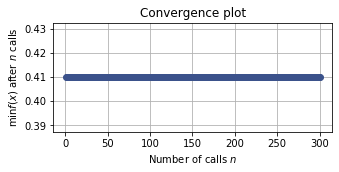

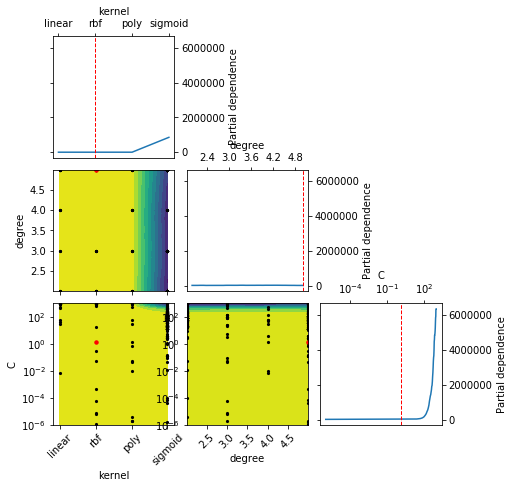

Wall time: 10min 2s


In [5]:
%%time

model = SVR()

dynamic_params_space  = [Categorical(['linear','rbf','poly','sigmoid'], name = 'kernel'),
                         Integer(2,5, name = 'degree'),
                         Real(1e-6, 1e+3, prior='log-uniform', name='C')]

HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

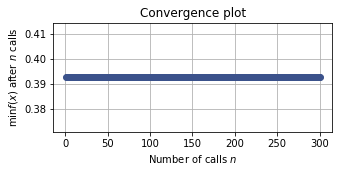

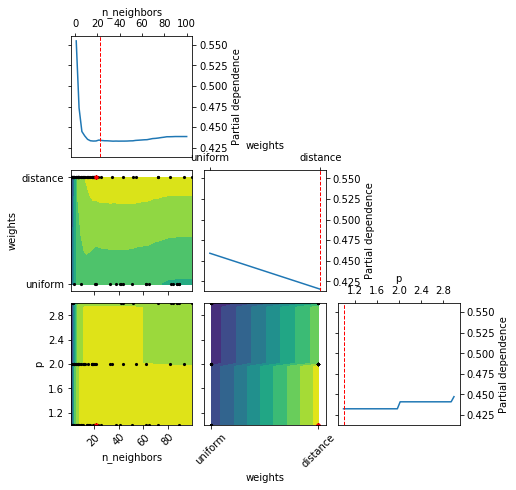

In [6]:
%%capture --no-display 

model = KNeighborsRegressor()

dynamic_params_space  = [Integer(1, 100, name='n_neighbors'),
                         Categorical(['uniform', 'distance'], name = 'weights'),
                         Integer(1, 3, name = 'p')]
                         
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

MLPRegressor model training...
Optimized parameters:     ['hidden_layer_sizes', 'activation', 'solver', 'learning_rate', 'alpha']
Previous best parameters: None
Current  best parameters: [(200,), 'tanh', 'adam', 'adaptive', 0.6728141670887439]
Best score: 0.41437841623159344


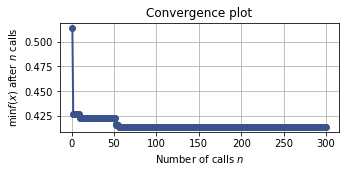

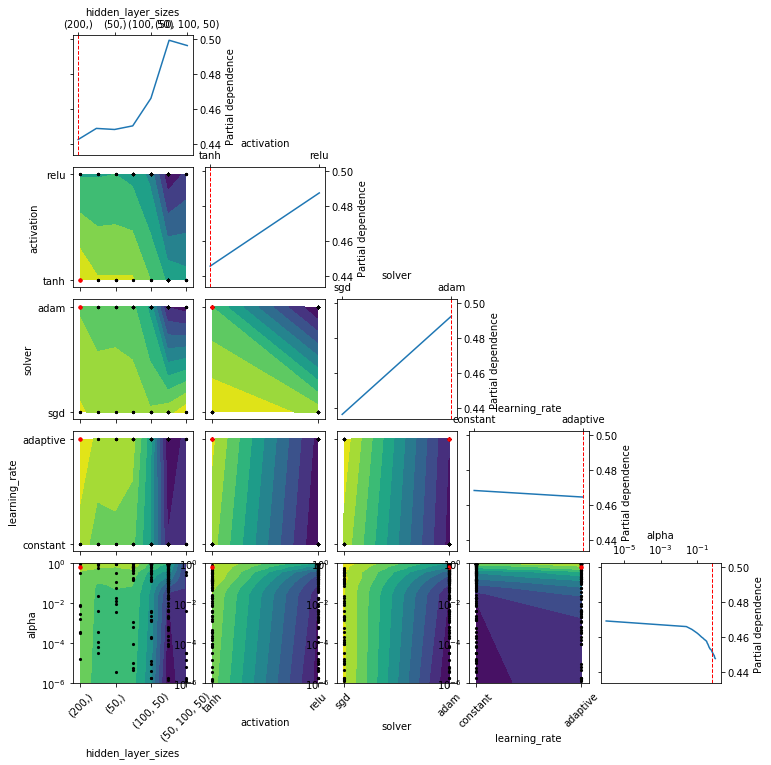

Wall time: 30min 56s


In [7]:
%%time

model = MLPRegressor(max_iter=1000)

dynamic_params_space  = [Categorical([(200,),(100,),(50,),(200,100,),(100,50,),(50,50,50),(50,100,50)], name='hidden_layer_sizes'),
                         Categorical(['tanh', 'relu'], name = 'activation'),
                         Categorical(['sgd', 'adam'], name = 'solver'),
                         Categorical(['constant', 'adaptive'], name = 'learning_rate'),
                         Real(1e-6, 1, prior='log-uniform', name='alpha')]


HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

ExtraTreesRegressor model training...


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Optimized parameters:     ['n_estimators', 'max_depth', 'min_samples_split']
Previous best parameters: [1016, 14, 2]
Current  best parameters: [97, 16, 4]
Best score: 0.36109857317666677


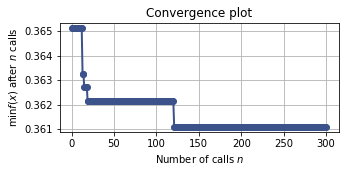

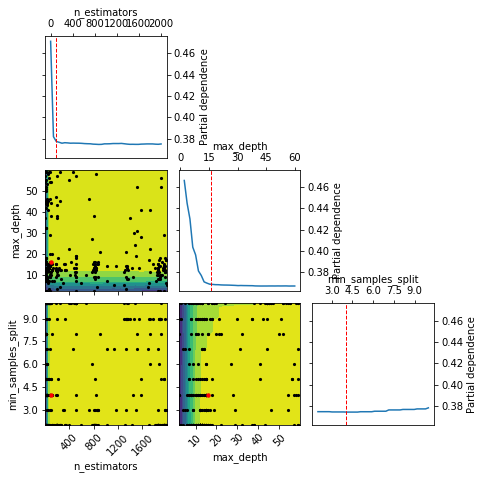

Wall time: 10min


In [8]:
%%time

model = ExtraTreesRegressor()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,60, name='max_depth'),
                         Integer(2,10, name='min_samples_split')]
                         
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error',  plot = True, **HPO_params)

RandomForestRegressor model training...
Optimized parameters:     ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
Previous best parameters: [1855, 115, 4, 2]
Current  best parameters: [1999, 41, 2, 1]
Best score: 0.37563004328520627


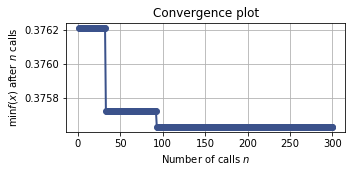

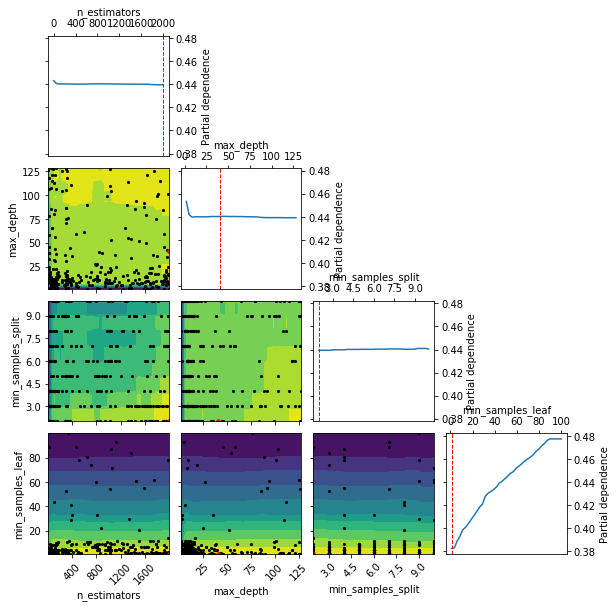

Wall time: 17min 36s


In [9]:
%%time
model = RandomForestRegressor()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,128, name='max_depth'),
                         Integer(2,10, name='min_samples_split'),
                         Integer(1,100, name='min_samples_leaf')]
                         
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

AdaBoostRegressor model training...
Optimized parameters:     ['n_estimators', 'learning_rate']
Previous best parameters: [1470, 0.014064866977256795]
Current  best parameters: [38, 0.4211771252059059]
Best score: 0.4166484523630438


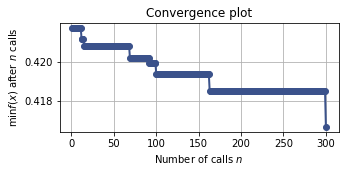

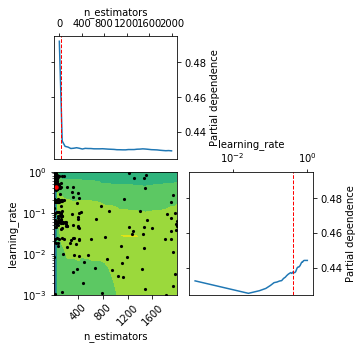

Wall time: 4min 32s


In [10]:
%%time

model = AdaBoostRegressor()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate')]

                         
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

GradientBoostingRegressor model training...
Optimized parameters:     ['n_estimators', 'max_depth', 'min_samples_split', 'learning_rate']
Previous best parameters: [1774, 5, 2, 0.0015606509092495836]
Current  best parameters: [64, 5, 2, 0.04572913715851015]
Best score: 0.4009858314271235


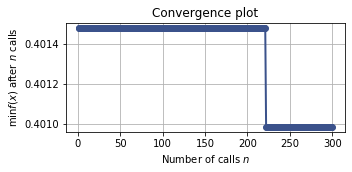

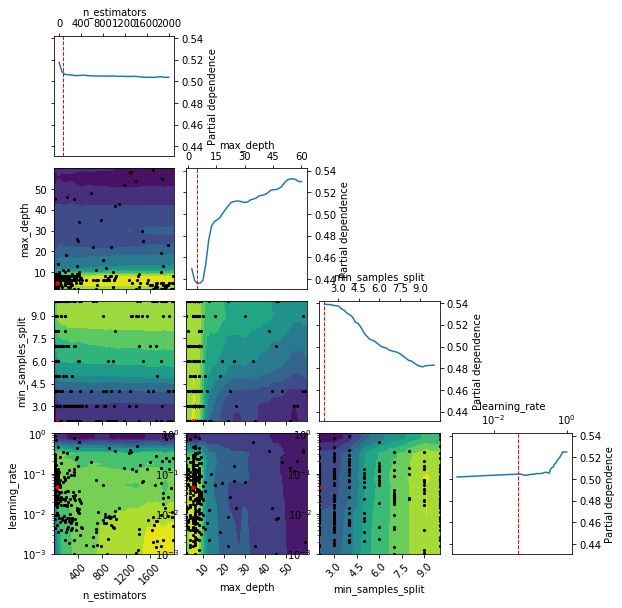

Wall time: 8min 8s


In [11]:
%%time

model = GradientBoostingRegressor()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,60, name='max_depth'),
                         Integer(2,10, name='min_samples_split'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate')]
                         
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train,  dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

LGBMRegressor model training...
Optimized parameters:     ['num_leaves', 'max_depth', 'min_child_samples', 'subsample_for_bin', 'reg_lambda', 'learning_rate']
Previous best parameters: [1581, 115, 18, 136479, 0.6740917632332863, 0.04554252369906913]
Current  best parameters: [909, 125, 18, 413335, 0.07962961666129881, 0.03440469813397418]
Best score: 0.3852013088909104


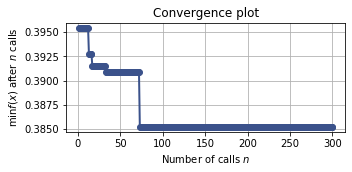

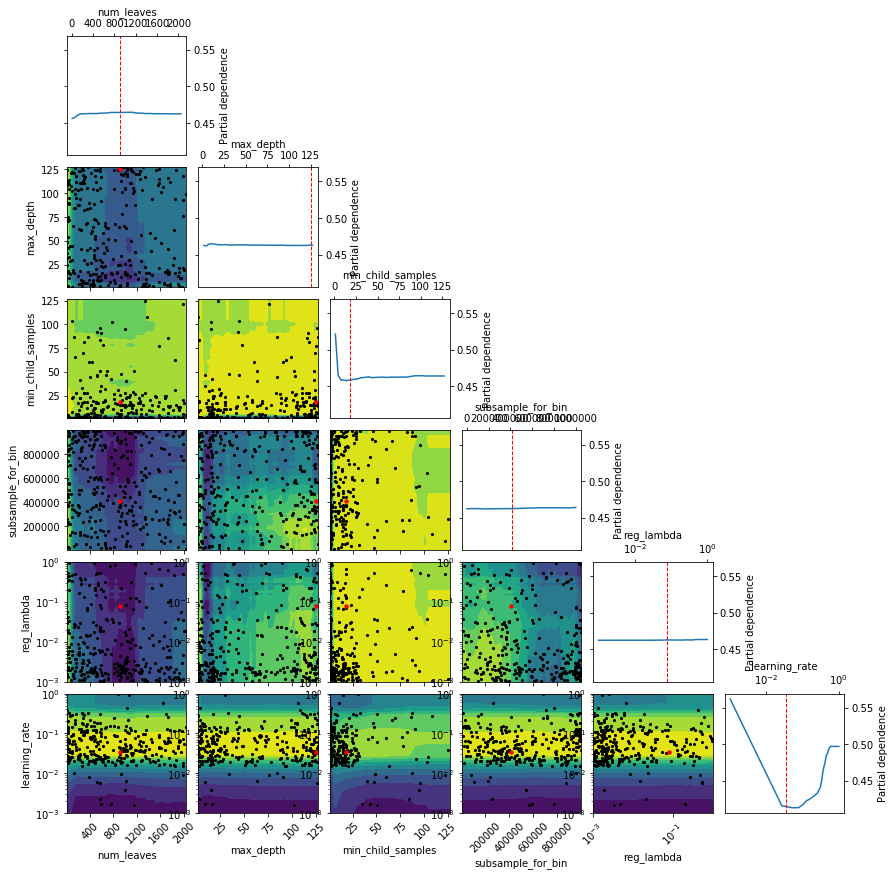

Wall time: 5min 21s


In [12]:
%%time
model = LGBMRegressor()

dynamic_params_space  = [Integer(7, 2047, name='num_leaves'),
                         Integer(2, 127, name='max_depth'),
                         Integer(1, 127, name='min_child_samples'),
                         Integer(1e3, 1e6, name='subsample_for_bin'),
                         Real(1e-3, 1, prior='log-uniform', name='reg_lambda'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate')]

HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}

find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error', plot = True, **HPO_params)

XGBRegressor model training...
Optimized parameters:     ['max_depth', 'min_child_weight', 'max_delta_step', 'subsample', 'reg_lambda', 'learning_rate']
Previous best parameters: [26, 0.0906044484952906, 5, 0.6482660666953227, 0.004730588441691412, 0.11776805579307988, 0.08808071819406763]
Current  best parameters: [26, 0.0906044484952906, 5, 0.6482660666953227, 0.004730588441691412, 0.11776805579307988, 0.08808071819406763]
Best score: 0.40085151895943616


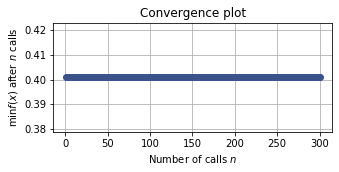

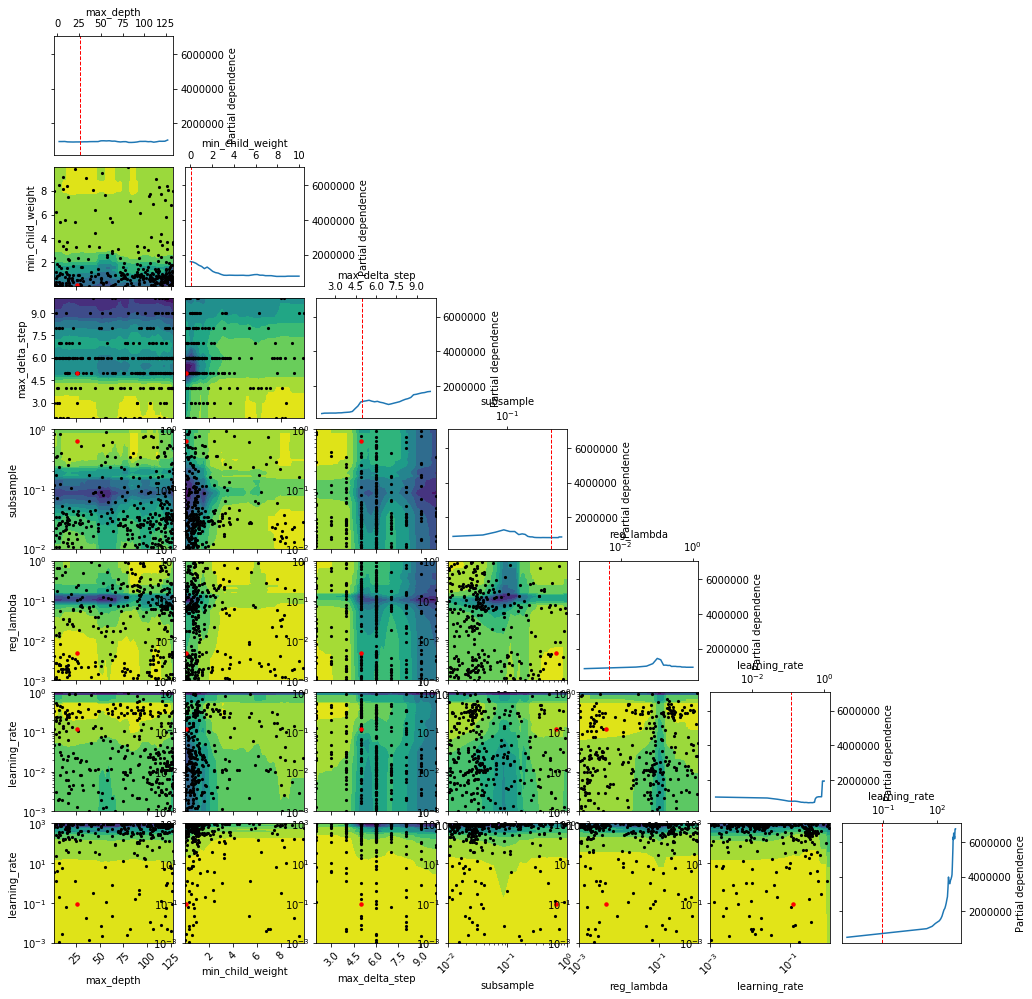

Wall time: 4min 57s


In [13]:
%%time
model = XGBRegressor()

dynamic_params_space  = [Integer(2, 127, name='max_depth'),
                         Real(0, 10, name='min_child_weight'),
                         Integer(2, 10, name='max_delta_step'),
                         Real(1e-2, 1, prior='log-uniform', name='subsample'),                         
                         Real(1e-3, 1, prior='log-uniform', name='reg_lambda'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate'),
                         Real(1e-3, 1e3, prior='log-uniform', name='learning_rate')]
    
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'neg_mean_squared_error',  plot = True, **HPO_params)

## Compare Regressors after Parameters Optimization

In [14]:
compare_regressors(regressors, X_train, y_train, X_test, y_test, n_splits=5, load_best_params=True, show_predicts=False, scoring = 'neg_mean_squared_error')

DummyRegressor parameters were not previously optimized
LinearRegression parameters were not previously optimized
SVR optimized parameters: {'kernel': 'rbf', 'degree': 5, 'C': 1.3358886335261617}
KNeighborsRegressor optimized parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 1}
MLPRegressor optimized parameters: {'hidden_layer_sizes': (200,), 'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'adaptive', 'alpha': 0.6728141670887439}
ExtraTreesRegressor optimized parameters: {'n_estimators': 97, 'max_depth': 16, 'min_samples_split': 4}
RandomForestRegressor optimized parameters: {'n_estimators': 1999, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1}
AdaBoostRegressor optimized parameters: {'n_estimators': 38, 'learning_rate': 0.4211771252059059}
GradientBoostingRegressor optimized parameters: {'n_estimators': 64, 'max_depth': 5, 'min_samples_split': 2, 'learning_rate': 0.04572913715851015}
LGBMRegressor optimized parameters: {'num_leaves': 909, 'max_depth'

,model,train_score,val_score,test_score,fit_time
0,ExtraTreesRegressor,0.015151,0.364130,0.363215,0.182578
1,RandomForestRegressor,0.049604,0.376445,0.365132,9.415880
2,KNeighborsRegressor,-0.000000,0.392569,0.372236,0.001988
3,LGBMRegressor,0.130439,0.385201,0.379794,0.104286
4,GradientBoostingRegressor,0.152412,0.400740,0.387138,0.135851
5,MLPRegressor,0.351889,0.412624,0.395083,2.508462
6,SVR,0.265417,0.409917,0.404667,0.031242
7,AdaBoostRegressor,0.337750,0.418889,0.406446,0.093700
8,XGBRegressor,0.000001,0.423277,0.415317,0.546730
9,LinearRegression,0.419722,0.440931,0.416049,0.000000


## Feature Importance

LGBMRegressor optimized parameters: {'num_leaves': 909, 'max_depth': 125, 'min_child_samples': 18, 'subsample_for_bin': 413335, 'reg_lambda': 0.07962961666129881, 'learning_rate': 0.03440469813397418}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


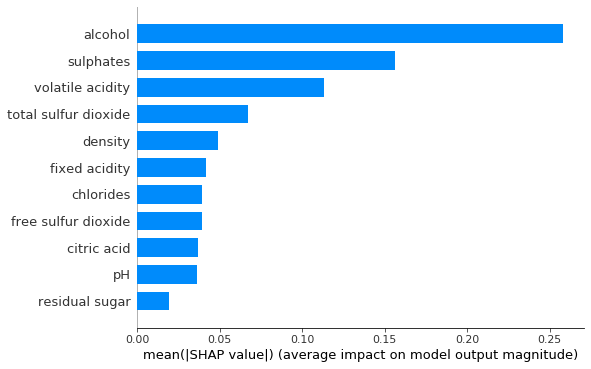

In [15]:
model = LGBMRegressor()

plot_shap_feature_importance(model, X_train, y_train)

## Ensemble

### Ensemble models
- Meta KFold scheme with OOF meta-features is used:
1. Lets say we have N diverse models with optimized hyperparameters
- for model in models:  
    get best hyperparameters for this model from file  
    using cross-validation calculate train predictions  
    y_train_predict = cross_val_predict(model, X_train, y_train, cv, seed = 42)  
    retrain the model using whole train set  
    model.fit(X_train,y_train)       
    predict for test set  
    y_test_predict = model.predict(X_test)  
Thus we obtained 
model_train_predict = (n_train_samples X n_models)
model_test_predict (n_test_samples X n_models).

2.
- Use KFold scheme on model_train_predict to validate hyperparameters for meta-model (e.g. lr). A common practice to fix seed for this KFold to be the same as seed for KFold used to get OOF predictions.
- When the meta-model is validated, fit it to train_meta and predict for test_meta.

In [16]:
regressors = [LinearRegression(),
              SVR(),
              KNeighborsRegressor(),
              MLPRegressor(random_state=seed,max_iter=2000),
              ExtraTreesRegressor(random_state=seed),
              RandomForestRegressor(random_state=seed),
              AdaBoostRegressor(random_state=seed),
              GradientBoostingRegressor(random_state=seed),
              LGBMRegressor(random_state=seed),
              XGBRegressor(random_state=seed)]

for model in regressors:
    get_train_test_predicts(model, X_train, y_train, X_test, y_test, seed)

LinearRegression
LinearRegression parameters were not previously optimized
train mse: 0.44097293703567486
test mse: 0.41604933541314953
Model predicts updated in file output/predicts/1st_level_regressors_train_predicts.csv
Model predicts updated in file output/predicts/1st_level_regressors_test_predicts.csv
SVR
SVR optimized parameters: {'kernel': 'rbf', 'degree': 5, 'C': 1.3358886335261617}
train mse: 0.40991756830589515
test mse: 0.5546049209678813
Model predicts updated in file output/predicts/1st_level_regressors_train_predicts.csv
Model predicts updated in file output/predicts/1st_level_regressors_test_predicts.csv
KNeighborsRegressor
KNeighborsRegressor optimized parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 1}
train mse: 0.3925537549451217
test mse: 0.47348083035100336
Model predicts updated in file output/predicts/1st_level_regressors_train_predicts.csv
Model predicts updated in file output/predicts/1st_level_regressors_test_predicts.csv
MLPRegressor
MLPRegressor 

test_mse: 0.363043920016146


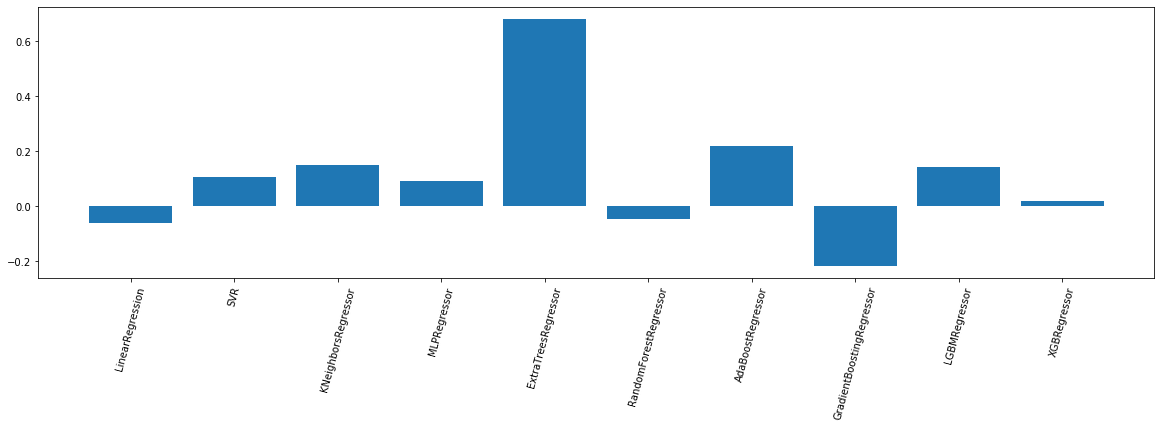

In [17]:
df_train_meta = pd.read_csv(r'output/predicts/1st_level_regressors_train_predicts.csv')
df_test_meta = pd.read_csv(r'output/predicts/1st_level_regressors_test_predicts.csv')

metamodel = LinearRegression()
metamodel.fit(df_train_meta, y_train)
importance = metamodel.coef_

y_test_predict_meta = metamodel.predict(df_test_meta)
MSE = mse(y_test, y_test_predict_meta)
MSE_round = mse(y_test, y_test_predict_meta)
print('test_mse:', MSE)

coord = list(range(len(importance)))
plt.bar(coord, importance)
labels = df_train_meta.columns.tolist()
plt.xticks(coord, labels, rotation=75)
plt.show()

In [18]:
print(accuracy_score(y_test, np.round(y_test_predict_meta)))

0.6647887323943662


In [19]:
metamodel = RandomForestRegressor(max_depth=2)
metamodel.fit(df_train_meta, y_train)
metamodel_predicts = metamodel.predict(df_test_meta)
print(mse(metamodel_predicts, y_test))

0.3660051696076644


In [20]:
# Compare predicts and true values 
print(y_test.value_counts(), pd.Series(np.round(y_test_predict_meta)).value_counts())

5    305
6    280
7     88
4     24
8      8
3      5
Name: quality, dtype: int64 6.0    347
5.0    310
7.0     50
4.0      3
dtype: int64
